# Architecture 1 - Sequential Neural Network

In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
from torch import nn
from torch import optim
from torchvision.datasets.utils import download_url
from torchvision import  datasets
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline
import seaborn as sns
import plotly.express as px
import time

from scipy.optimize import least_squares

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

import imageio
import math
import csv
import os
from tqdm.notebook import tqdm
from IPython.display import HTML
import pickle
from pickle import dump
from pickle import load


from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Determine device type for using GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train NN

### Custom Data set for each batch

In [2]:
class customDataset(Dataset):
    
    def __init__(self, X_data, y_data1,y_data2):
        self.X_data = X_data
        self.y_data1 = y_data1
        self.y_data2 = y_data2
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data1[index], self.y_data2[index]
        
    def __len__ (self):
        return len(self.X_data)

### Import the train data
1. Split into trian and validation
2. Scale the train dataset and validation dataset
3. Split the data into batches using the class customDataset

In [3]:

df_csv = pd.read_csv('scenario91_real_data_30k.csv')
X = df_csv.iloc[:, 0:-2]
y = df_csv.iloc[:, 30:32]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05,  random_state=59,shuffle=True)
print(type(X_train))
scaler = MinMaxScaler()

sc = scaler.fit(X_train)
X_train_sc = sc.transform(X_train)

X_val_sc = sc.transform(X_val)

X_train, y_train1,y_train2 = np.array(X_train_sc), np.array(y_train[:]["go_x"]),np.array(y_train[:]["go_y"])
print(type(X_train))

X_val,y_val1,y_val2 = np.array(X_val_sc), np.array(y_val[:]["go_x"]), np.array(y_val[:]["go_y"])
    
train_dataset = customDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train1).float(), torch.from_numpy(y_train2).float())
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

val_dataset = customDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val1).float(), torch.from_numpy(y_val2).float())
val_loader = DataLoader(dataset=val_dataset, batch_size=1000, shuffle=True)


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [27]:
X_train_sc[0]

array([0.43866787, 0.43811206, 0.55029032, 0.4589676 , 0.56853478,
       0.42421062, 0.53883367, 0.44410506, 0.61311253, 0.59833742,
       0.54249892, 0.71421703, 0.46954056, 0.6192366 , 0.72147148,
       0.35276813, 0.80841059, 0.88518342, 0.62002005, 0.27614587,
       0.04015167, 0.72804168, 0.67069391, 0.91424338, 0.61554092,
       0.35510118, 0.77817742, 0.71430805, 0.99192418, 0.817321  ])

In [11]:
sc.n_features_in_

30

### Define a Sequential neural network architecture

In [4]:
class newnn(nn.Module):
    def __init__(self):
        super().__init__()
        # ----Apply FCL on concatenated Coordinates & time measurements----
        self.fc1 = nn.Linear(30, 64)
        self.leakyrelu1 = nn.LeakyReLU() 
        
        self.fc2 = nn.Linear(64, 128)
        self.leakyrelu2 = nn.LeakyReLU() 
        
        self.fc3 = nn.Linear(128, 196)
        self.bn3 = nn.BatchNorm1d(196)
        self.leakyrelu3 = nn.LeakyReLU() 
        
        self.fc4 = nn.Linear(196, 128) 
        self.dropout1 = nn.Dropout(0.1)
        self.leakyrelu4 = nn.LeakyReLU() 
        
        self.fc5 = nn.Linear(128, 64) 
        self.leakyrelu5 = nn.LeakyReLU() 
        
        self.fc6 = nn.Linear(64, 32) 
        self.leakyrelu6 = nn.LeakyReLU() 
        
        self.fc7 = nn.Linear(32, 2) 
        
    def forward(self,y):
        y = self.fc1(y)
        y = self.leakyrelu1(y)
        
        y = self.fc2(y)
        y = self.leakyrelu2(y)
        
        y = self.fc3(y)        
        y = self.leakyrelu3(self.bn3 (y))
        
        y = self.fc4(y)
        y = self.dropout1(y)
        y = self.leakyrelu4(y)
        
        y = self.fc5(y)
        y = self.leakyrelu5(y)
        
        y = self.fc6(y)
        y = self.leakyrelu6(y)
        
        y = self.fc7(y)

        return y

### Model training and evaluate on validation set

In [5]:
#Below block of code trians optimized multi layer neural net with whole of training dataset

learning_rate = 0.0001
EPOCHS =1000

model_s9_original = newnn()
model_s9_original = model_s9_original.to(device)    

loss_fn1 = nn.MSELoss()
loss_fn2 = nn.MSELoss()
optimizer = torch.optim.Adam(model_s9_original.parameters(), lr=learning_rate)

loss_stats = {
    'train': [],
    "val": []
}
start_time = time.time()
%time # Measure the time of execussion
train_epoch_loss = 0.0

print("scenario - Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    train_epoch_loss=0
    model_s9_original.train()
    for data, target1,target2 in train_loader:
        data, target1,target2 = data.to(device), target1.to(device), target2.to(device)
        optimizer.zero_grad()
        out = model_s9_original(data)  
        out1 =out[:, 0]
        out2 =out[:, 1]

        train_loss1 = loss_fn1(out1, target1)     
        train_loss2 = loss_fn2(out2, target2)  
        train_loss = torch.add(train_loss1, train_loss2)
        writer.add_scalar("Loss/train", train_loss, train_epoch_loss)
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()        
        
    # Evaluate on validation set
    with torch.no_grad():        
        val_epoch_loss = 0       
        model_s9_original.eval()
        for vdata, vtarget1,vtarget2 in val_loader:
            vdata, vtarget1,vtarget2 = vdata.to(device), vtarget1.to(device),vtarget2.to(device)    
            vout = model_s9_original(vdata) 
            vout1 =vout[:, 0]
            vout2 =vout[:, 1]
            val_loss1 = loss_fn1(vout1, vtarget1)    
            val_loss2 = loss_fn2(vout2, vtarget2) 

            val_loss = torch.add(val_loss1, val_loss2)
            val_epoch_loss += val_loss.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))      

    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')
print("--- %s seconds ---" % (time.time() - start_time)) 
writer.flush()
writer.close()

Wall time: 0 ns
scenario2 - Begin training.


Epoch 001: | Train Loss: 51.13463 | Val Loss: 22.56238
Epoch 002: | Train Loss: 20.68100 | Val Loss: 17.45795
Epoch 003: | Train Loss: 17.33997 | Val Loss: 15.86033
Epoch 004: | Train Loss: 16.03678 | Val Loss: 14.86270
Epoch 005: | Train Loss: 14.98170 | Val Loss: 13.93220
Epoch 006: | Train Loss: 14.29245 | Val Loss: 13.08993
Epoch 007: | Train Loss: 13.54504 | Val Loss: 12.35097
Epoch 008: | Train Loss: 12.91866 | Val Loss: 12.03264
Epoch 009: | Train Loss: 12.24117 | Val Loss: 11.52870
Epoch 010: | Train Loss: 11.48578 | Val Loss: 10.91077
Epoch 011: | Train Loss: 10.82223 | Val Loss: 10.45916
Epoch 012: | Train Loss: 10.25897 | Val Loss: 9.65162
Epoch 013: | Train Loss: 9.78021 | Val Loss: 9.32668
Epoch 014: | Train Loss: 9.34715 | Val Loss: 8.58095
Epoch 015: | Train Loss: 8.81614 | Val Loss: 8.76289
Epoch 016: | Train Loss: 8.41582 | Val Loss: 8.39743
Epoch 017: | Train Loss: 8.07726 | Val Loss: 7.63802
Epoch 018: | Train Loss: 7.73835 | Val Loss: 7.19316
Epoch 019: | Train Loss

Epoch 156: | Train Loss: 1.50955 | Val Loss: 1.90213
Epoch 157: | Train Loss: 1.47328 | Val Loss: 1.80461
Epoch 158: | Train Loss: 1.55481 | Val Loss: 2.05362
Epoch 159: | Train Loss: 1.46205 | Val Loss: 1.90005
Epoch 160: | Train Loss: 1.45738 | Val Loss: 1.84513
Epoch 161: | Train Loss: 1.47814 | Val Loss: 2.03363
Epoch 162: | Train Loss: 1.49516 | Val Loss: 1.65089
Epoch 163: | Train Loss: 1.50185 | Val Loss: 1.99931
Epoch 164: | Train Loss: 1.47682 | Val Loss: 1.96991
Epoch 165: | Train Loss: 1.42870 | Val Loss: 1.93777
Epoch 166: | Train Loss: 1.42524 | Val Loss: 2.06792
Epoch 167: | Train Loss: 1.42146 | Val Loss: 1.86172
Epoch 168: | Train Loss: 1.46149 | Val Loss: 1.85122
Epoch 169: | Train Loss: 1.47305 | Val Loss: 1.82451
Epoch 170: | Train Loss: 1.44978 | Val Loss: 1.78261
Epoch 171: | Train Loss: 1.42755 | Val Loss: 1.94008
Epoch 172: | Train Loss: 1.40953 | Val Loss: 2.00644
Epoch 173: | Train Loss: 1.37887 | Val Loss: 1.88314
Epoch 174: | Train Loss: 1.45147 | Val Loss: 2

Epoch 311: | Train Loss: 0.98958 | Val Loss: 1.59875
Epoch 312: | Train Loss: 1.01169 | Val Loss: 1.56413
Epoch 313: | Train Loss: 1.01540 | Val Loss: 1.55470
Epoch 314: | Train Loss: 0.98434 | Val Loss: 1.78939
Epoch 315: | Train Loss: 0.97723 | Val Loss: 1.69037
Epoch 316: | Train Loss: 0.97604 | Val Loss: 1.92661
Epoch 317: | Train Loss: 1.02127 | Val Loss: 1.65514
Epoch 318: | Train Loss: 1.00617 | Val Loss: 1.64161
Epoch 319: | Train Loss: 1.01571 | Val Loss: 1.86736
Epoch 320: | Train Loss: 0.97710 | Val Loss: 1.89873
Epoch 321: | Train Loss: 1.02315 | Val Loss: 1.61066
Epoch 322: | Train Loss: 0.96889 | Val Loss: 1.76503
Epoch 323: | Train Loss: 0.99442 | Val Loss: 1.74515
Epoch 324: | Train Loss: 0.97539 | Val Loss: 1.67194
Epoch 325: | Train Loss: 0.97450 | Val Loss: 1.82105
Epoch 326: | Train Loss: 0.95301 | Val Loss: 1.75340
Epoch 327: | Train Loss: 1.05077 | Val Loss: 1.70196
Epoch 328: | Train Loss: 0.97112 | Val Loss: 1.77022
Epoch 329: | Train Loss: 1.02100 | Val Loss: 1

Epoch 466: | Train Loss: 0.79611 | Val Loss: 1.88751
Epoch 467: | Train Loss: 0.81232 | Val Loss: 1.56095
Epoch 468: | Train Loss: 0.79232 | Val Loss: 1.63962
Epoch 469: | Train Loss: 0.84232 | Val Loss: 1.75752
Epoch 470: | Train Loss: 0.81018 | Val Loss: 1.53301
Epoch 471: | Train Loss: 0.81051 | Val Loss: 1.74158
Epoch 472: | Train Loss: 0.79448 | Val Loss: 1.64606
Epoch 473: | Train Loss: 0.80246 | Val Loss: 1.42022
Epoch 474: | Train Loss: 0.83661 | Val Loss: 1.72742
Epoch 475: | Train Loss: 0.80676 | Val Loss: 1.72895
Epoch 476: | Train Loss: 0.79685 | Val Loss: 1.74100
Epoch 477: | Train Loss: 0.78174 | Val Loss: 1.51019
Epoch 478: | Train Loss: 0.80879 | Val Loss: 1.50283
Epoch 479: | Train Loss: 0.85204 | Val Loss: 1.70786
Epoch 480: | Train Loss: 0.77235 | Val Loss: 1.54687
Epoch 481: | Train Loss: 0.80982 | Val Loss: 1.72728
Epoch 482: | Train Loss: 0.84325 | Val Loss: 1.64093
Epoch 483: | Train Loss: 0.80933 | Val Loss: 1.67229
Epoch 484: | Train Loss: 0.76846 | Val Loss: 1

Epoch 621: | Train Loss: 0.71082 | Val Loss: 1.35745
Epoch 622: | Train Loss: 0.68871 | Val Loss: 1.53875
Epoch 623: | Train Loss: 0.70294 | Val Loss: 1.39293
Epoch 624: | Train Loss: 0.69453 | Val Loss: 1.44123
Epoch 625: | Train Loss: 0.69050 | Val Loss: 1.55078
Epoch 626: | Train Loss: 0.67578 | Val Loss: 1.45247
Epoch 627: | Train Loss: 0.70099 | Val Loss: 1.58473
Epoch 628: | Train Loss: 0.69835 | Val Loss: 1.37122
Epoch 629: | Train Loss: 0.69567 | Val Loss: 1.62733
Epoch 630: | Train Loss: 0.68775 | Val Loss: 1.40188
Epoch 631: | Train Loss: 0.70722 | Val Loss: 1.45362
Epoch 632: | Train Loss: 0.69351 | Val Loss: 1.59340
Epoch 633: | Train Loss: 0.68358 | Val Loss: 1.41981
Epoch 634: | Train Loss: 0.69145 | Val Loss: 1.50213
Epoch 635: | Train Loss: 0.76404 | Val Loss: 1.75495
Epoch 636: | Train Loss: 0.69434 | Val Loss: 1.62831
Epoch 637: | Train Loss: 0.70194 | Val Loss: 1.69527
Epoch 638: | Train Loss: 0.70779 | Val Loss: 1.37296
Epoch 639: | Train Loss: 0.70232 | Val Loss: 1

Epoch 776: | Train Loss: 0.64208 | Val Loss: 1.51278
Epoch 777: | Train Loss: 0.62652 | Val Loss: 1.18862
Epoch 778: | Train Loss: 0.61588 | Val Loss: 1.29646
Epoch 779: | Train Loss: 0.62777 | Val Loss: 1.35651
Epoch 780: | Train Loss: 0.64948 | Val Loss: 1.22580
Epoch 781: | Train Loss: 0.63390 | Val Loss: 1.61176
Epoch 782: | Train Loss: 0.63033 | Val Loss: 1.25595
Epoch 783: | Train Loss: 0.61209 | Val Loss: 1.37546
Epoch 784: | Train Loss: 0.62259 | Val Loss: 1.30185
Epoch 785: | Train Loss: 0.61524 | Val Loss: 1.33679
Epoch 786: | Train Loss: 0.62915 | Val Loss: 1.42584
Epoch 787: | Train Loss: 0.63597 | Val Loss: 1.24963
Epoch 788: | Train Loss: 0.61935 | Val Loss: 1.46875
Epoch 789: | Train Loss: 0.64876 | Val Loss: 1.55149
Epoch 790: | Train Loss: 0.62847 | Val Loss: 1.71466
Epoch 791: | Train Loss: 0.62000 | Val Loss: 1.24958
Epoch 792: | Train Loss: 0.61991 | Val Loss: 1.49017
Epoch 793: | Train Loss: 0.59535 | Val Loss: 1.59371
Epoch 794: | Train Loss: 0.63953 | Val Loss: 1

Epoch 931: | Train Loss: 0.59225 | Val Loss: 1.40475
Epoch 932: | Train Loss: 0.57846 | Val Loss: 1.19038
Epoch 933: | Train Loss: 0.56528 | Val Loss: 1.54329
Epoch 934: | Train Loss: 0.56766 | Val Loss: 1.30826
Epoch 935: | Train Loss: 0.57959 | Val Loss: 1.41183
Epoch 936: | Train Loss: 0.59003 | Val Loss: 1.40142
Epoch 937: | Train Loss: 0.57869 | Val Loss: 1.38485
Epoch 938: | Train Loss: 0.57631 | Val Loss: 1.34310
Epoch 939: | Train Loss: 0.56726 | Val Loss: 1.42486
Epoch 940: | Train Loss: 0.57427 | Val Loss: 1.28112
Epoch 941: | Train Loss: 0.57576 | Val Loss: 1.41576
Epoch 942: | Train Loss: 0.56852 | Val Loss: 1.47958
Epoch 943: | Train Loss: 0.59232 | Val Loss: 1.48537
Epoch 944: | Train Loss: 0.56759 | Val Loss: 1.45518
Epoch 945: | Train Loss: 0.59875 | Val Loss: 1.41008
Epoch 946: | Train Loss: 0.61215 | Val Loss: 1.35991
Epoch 947: | Train Loss: 0.55639 | Val Loss: 1.27673
Epoch 948: | Train Loss: 0.59799 | Val Loss: 1.39032
Epoch 949: | Train Loss: 0.58669 | Val Loss: 1

### Save and Load model

In [6]:
from pickle import dump
dump(scaler, open('scalar_final1.pkl', 'wb'))
torch.save(model_s9_original, "model_final1")

In [7]:
scaler_loaded9 = load(open('scalar_final1.pkl', 'rb'))
scaler_loaded9
loaded_model_s9 = torch.load("model_final1")

In [24]:
np.finfo(np.float64).eps
np.finfo(np.float64)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

### Print Loss function epoch vs loss

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

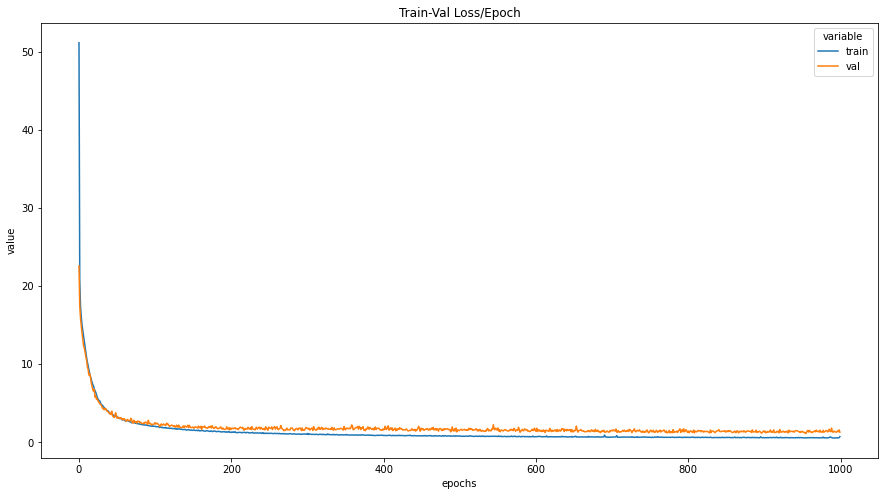

In [9]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')